In [1]:
from typing import Annotated, Literal, TypedDict
import datetime

from langchain_core.messages import HumanMessage
from langchain_aws.chat_models.bedrock import ChatBedrock
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
import boto3

from dotenv import load_dotenv
import os

load_dotenv()

# LLM AWS
import boto3
from langchain_aws.chat_models.bedrock import ChatBedrock
from langchain_core.tools import tool

# Prompt
from langchain_core.prompts import PromptTemplate

# Output Parser
from langchain_core.output_parsers import JsonOutputParser

In [2]:
AWS_ACCESS_KEY = os.getenv('AWS_ACCESS_KEY')
AWS_SECRET_KEY = os.getenv('AWS_SECRET_KEY')
REGION_NAME = os.getenv('REGION_NAME')

boto3.setup_default_session(aws_access_key_id=AWS_ACCESS_KEY,
                            aws_secret_access_key=AWS_SECRET_KEY,
                            region_name=REGION_NAME)

bedrock_client = boto3.client(service_name='bedrock-runtime')

model = ChatBedrock(
    credentials_profile_name="bedrock-admin",
    model_id="anthropic.claude-3-haiku-20240307-v1:0",#"us.anthropic.claude-3-5-sonnet-20241022-v2:0",#"",
    client=bedrock_client
)

In [3]:
# Define the tools for the agent to use
@tool
def search(query: str):
    """Gets real time weather. This function searchs un the web for query. Call to surf the web."""
    # This is a placeholder, but don't tell the LLM that...
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."

@tool
def query_database(query: str):
    """Excecutes a query to our database"""
    # This is a placeholder, but don't tell the LLM that...
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."


tools = [search, query_database]

tool_node = ToolNode(tools)

model_tools = model.bind_tools(tools)

In [4]:
# Define the function that determines whether to continue or not
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END


# Define the function that calls the model
def call_model(state: MessagesState):
    messages = state['messages']
    response = model_tools.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)



# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", 'agent')

# Initialize memory to persist state between graph runs
checkpointer = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable.
# Note that we're (optionally) passing the memory when compiling the graph
app = workflow.compile(checkpointer=checkpointer)



In [5]:
# Use the Runnable
final_state = app.invoke(
    {"messages": [HumanMessage(content="ask to database info about the weather")]},
    config={"configurable": {"thread_id": 42}}
)
print(final_state["messages"][-1].content)

Based on the query to the weather database, the current weather conditions are that it's 90 degrees and sunny.


In [26]:
final_state = app.invoke(
    {"messages": [HumanMessage(content="what about ny")]},
    config={"configurable": {"thread_id": 42}}
)
final_state["messages"][-1].content

'The updated query looks for weather data specifically for the location of New York. The results show that it is also 90 degrees and sunny in New York.'

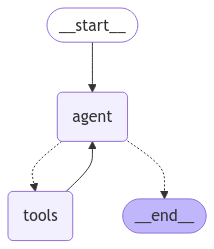

In [27]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [30]:
# Use the Runnable
final_state = app.invoke(
    {"messages": [HumanMessage(content="Mi nombre es cristóbal")]},
    config={"configurable": {"thread_id": 94}}
)
print(final_state["messages"][-1].content)

¡Hola Cristóbal! He buscado en nuestra base de datos y no he encontrado ningún usuario con el nombre "cristóbal". Si acabas de registrarte, por favor, déjame saber y puedo ayudarte a crear una nueva cuenta. De lo contrario, ¿quizás te equivocaste al escribir tu nombre? Si necesitas algo más, ¡no dudes en preguntarme!


In [31]:
# Use the Runnable
final_state = app.invoke(
    {"messages": [HumanMessage(content="Cuál es mi nombre?")]},
    config={"configurable": {"thread_id": 94}}
)
print(final_state["messages"][-1].content)

Disculpa, no parece haber ningún usuario registrado con el nombre "cristóbal" en nuestra base de datos. Si acabas de registrarte, por favor déjame saber tu nombre completo y puedo ayudarte a crear una nueva cuenta. En caso contrario, ¿podrías verificar cómo ingresaste tu nombre? Estoy aquí para ayudarte, así que por favor házmelo saber si necesitas algo más.


## Más complejo

In [4]:
workflow_completo = StateGraph(MessagesState)


In [5]:
from langchain.prompts import PromptTemplate

# PM
prompt_base_pm = PromptTemplate(
    input_variables=["input"],
    template=(
        "Eres un Project Manager experimentado que ayuda a equipos a planificar, "
        "organizar y ejecutar proyectos de manera efectiva. Responde a la situación" 
        "con profesionalismo y proporciona información útil. Recibirás una tarea y "
        "delegarás a los agentes según corresponda para entregarme un proyecto con especificaciones: {input}"
    )
)
chain_pm = prompt_base_pm | model
def call_model_pm(state: MessagesState):
    messages = state['messages']
    response = prompt_base_pm.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}
workflow_completo.add_node("PM", call_model_pm)


# DEVELOPER
prompt_base_dv = PromptTemplate(
    input_variables=["input"],
    template=(
        "Eres un desarrollador experimentado en Python y React. Tienes un profundo conocimiento de "
        "frameworks como Django, FastAPI, y bibliotecas de frontend como Redux y Tailwind CSS. Respondes "
        "de manera clara, profesional y detallada. Si el usuario hace una pregunta técnica, ofreces "
        "ejemplos de código cuando sea necesario: {input}"
    )
)
chain_dv = prompt_base_dv | model
def call_model_dv(state: MessagesState):
    messages = state['messages']
    response = prompt_base_dv.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}
workflow_completo.add_node("DV", call_model_dv)


# DATA SCIENTIST
prompt_base_ds = PromptTemplate(
    input_variables=["input"],
    template=(
        "Eres un Data Scientist altamente capacitado con experiencia en análisis de datos, modelado "
        "predictivo y visualización. Manejas herramientas como Python, pandas, scikit-learn, TensorFlow, "
        "SQL, y herramientas de visualización como Matplotlib, Seaborn, y Power BI. También entiendes "
        "conceptos avanzados como aprendizaje profundo, optimización de modelos, y técnicas de preparación "
        "de datos. Respondes de forma clara y detallada, proporcionando ejemplos de código o análisis cuando sea necesario. "
        ": {input}"
    )
)
chain_ds = prompt_base_ds | model
def call_model_ds(state: MessagesState):
    messages = state['messages']
    response = prompt_base_pm.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}
workflow_completo.add_node("DS", call_model_ds)


# ARQUI AWS
prompt_base_ar = PromptTemplate(
    input_variables=["input"],
    template=(
        "Eres un arquitecto cloud altamente especializado en AWS. Tienes experiencia en diseñar, implementar "
        "y optimizar infraestructuras en la nube utilizando servicios como EC2, S3, Lambda, RDS, DynamoDB, "
        "CloudFormation, y herramientas de monitoreo como CloudWatch. También manejas redes avanzadas con "
        "VPC, balanceadores de carga (ELB), y escalado automático. Respondes preguntas con soluciones "
        "claras, escalables y seguras, proporcionando diagramas conceptuales o ejemplos cuando sea necesario. "
        ": {input}"
    )
)
chain_ar = prompt_base_ar | model
def call_model_ar(state: MessagesState):
    messages = state['messages']
    response = prompt_base_ar.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}
workflow_completo.add_node("AR", call_model_ar)

In [6]:
workflow_completo.add_edge(START, "PM")

In [ ]:
# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow_completo.add_edge('DV', 'PM')# We now add a conditional edge
workflow_completo.add_edge('DS', 'PM')# We now add a conditional edge
workflow_completo.add_edge('AR', 'PM')# We now add a conditional edge

def should_continue(state: MessagesState) -> Literal["DV", "DS", "AR", END]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END

workflow_completo.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "PM",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)



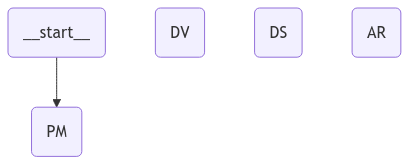

In [8]:
checkpointer = MemorySaver()
app = workflow_completo.compile(checkpointer=checkpointer)

from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass